# Final Notebook

En este notebook se muestra el proceso final derivado del resto de notebooks (Data_Exploration, Feature_Engineering, Model_Selection...), de modo que se pueda seguir de un modo sencillo el proceso final

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

%matplotlib inline

In [2]:
data = pd.read_csv('ds_job.csv')

## 1. Data exploration

El proceso de exploración de datos se puede seguir más en profundidad en el notebook Data_Exploration. Aquí, únicamente mostraremos la distribución que siguen los datos para tener una idea general de cómo son:

array([[<AxesSubplot:title={'center':'empleado_id'}>,
        <AxesSubplot:title={'center':'indice_desarrollo_ciudad'}>],
       [<AxesSubplot:title={'center':'horas_formacion'}>,
        <AxesSubplot:title={'center':'target'}>]], dtype=object)

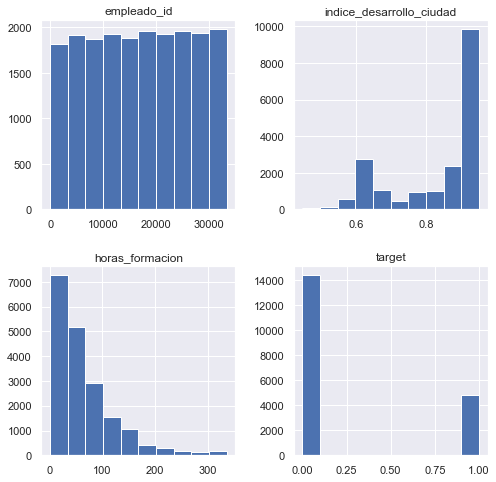

In [3]:
data.hist(figsize=(8,8))

El dataset está ciertamente desbalanceado, en una proporción aproximada del 75% para la clase *0* y un 25% para la clase *1*. Esto ha provocado que tengamos que buscar soluciones para mejorar el rendimiento del modelo y que no se base en una elección aleatoria. Más adelante en este notebook se indica cómo realizamos un Random Oversampling para tratar de paliar este problema.

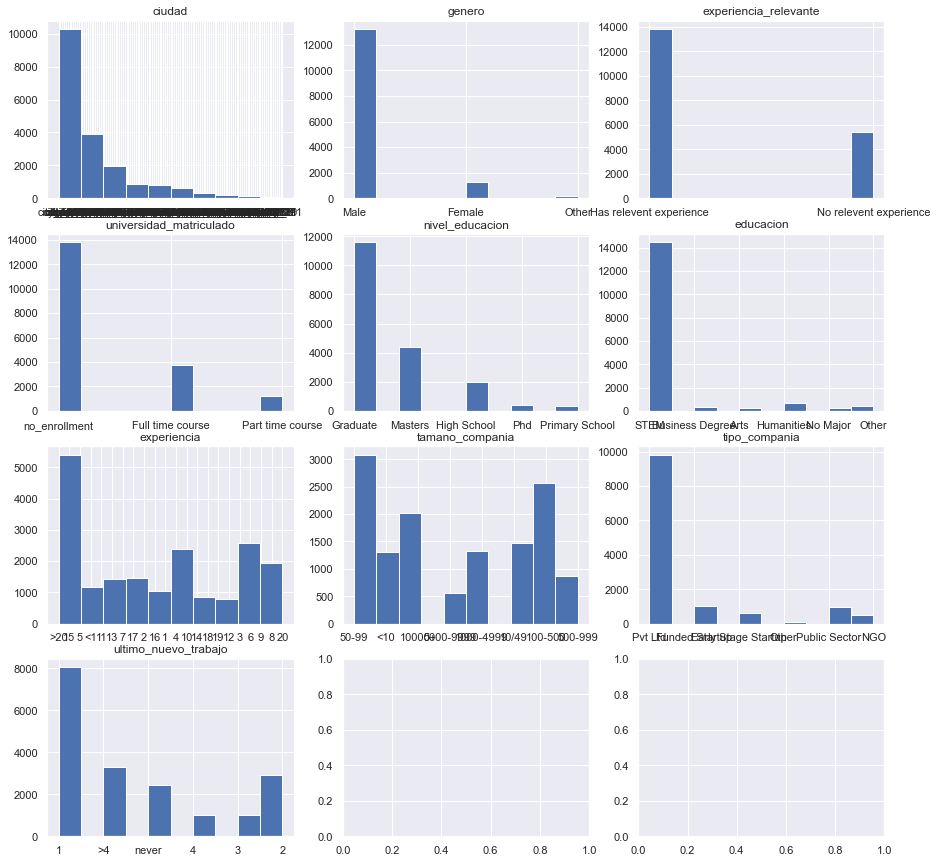

In [4]:
cols = [i for i in data if data[str(i)].dtype == 'O']
nrows=4
ncols=3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, sharey=False, figsize=(15,15))
for i in range(4):
    for j in range(3):
        idx = (nrows-1)*i+j
        if idx < len(cols):
            ax[i, j].hist(data[cols[idx]].dropna())
            ax[i, j].set_title(cols[idx])
plt.show()

# 2. Feature engineering

En el notebook Feature_Engineering se puede encontrar el análisis completo realizado, donde se muestran todas las variables que se han probado para tratar de mejorar el modelo. Aquí únicamente vamos a emplear una nueva variable construida a partir de las variables *experiencia* y *experiencia_relevante*, ya que ha sido la que ha mostrado una ligera mejora en el score final del modelo.

En primer lugar, procedemos a bucketizar los años de experiencia, de modo que tengamos una variable más ligera. Posteriormente, creamos otra función encargada de combinar dos variables:

In [8]:
## Función para discretizar la variable experiencia en buckets
def buckets_experiencia(x, limits = [6, 20]):
    try:
        x = int(x)
        for i in limits:
            if x <= i:
                return '<' + str(i)
    except:
        if x == 'nan':
            return np.nan
        return x
    
# Función que permite unir dos variables discretas
def combine_buckets(x1, x2):
    if str(x1) != 'nan' and str(x2) != 'nan':
        #Cogemos solo la primera palabra de cada variable para que no sea tan larga
        return str(x1).split(' ')[0] + '_' + str(x2).split(' ')[0] 
    else: 
        return np.nan
    return x1

De este modo, si aplicásemos la función sobre las dos variables comentadas, obtendríamos una nueva feature con los siguientes valores:

<AxesSubplot:>

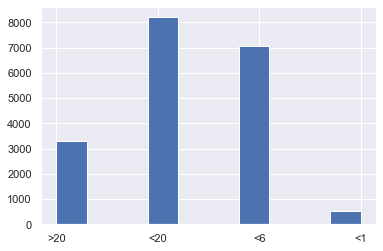

In [27]:
data['new_exp'] = data.experiencia.apply(lambda x: str(x))
data['new_exp'] = data.new_exp.apply(buckets_experiencia)
data['new_exp'].hist()

Valores de la variable final:

In [28]:
data['new_feature'] = data.apply(lambda x: combine_buckets(x.new_exp, x.experiencia_relevante), axis=1)

<AxesSubplot:>

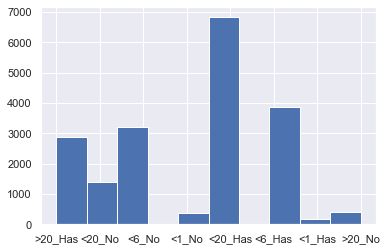

In [31]:
data['new_feature'].hist()

## 3. Pipeline

Una vez tenemos las transformaciones que deseamos, vamos a proceder a crear unas clases que nos permitan aplicar estas y otras transformaciones al conjunto de datos de forma automatizada:

In [9]:
# Función encargada de llamar a la función combine_buckets de manera correcta para combinar variables
def combine_features(data, col1, col2, new_col_name, f1=None, f2=None):
    """This function combines two features calling the combine_buckets function.
    Args:
    data (DataFrame): whole dataset
    col1 (str): name of the first column to combine
    col2 (str): name of the second column to combine
    new_col_name (str): name for the new variable
    f1 (str) optional: optional function to apply to the first column
    f2 (str) optional: optional function to apply to the second column
    
    Returns:
    data1 (DataFrame): new dataset with the new variable"""

    data1 = data.copy()
    # Convertimos todos las variables a string
    # Diferenciamos en función de si la entrada es un dataframe o un series
    if isinstance(data1, pd.DataFrame):
        data1['new_'+col1] = data1[col1].apply(lambda x: str(x))
        data1['new_'+col2] = data1[col2].apply(lambda x: str(x))
       

        # Si hay funciones previas que han de ser aplicadas, lo hacemos 
        if f1 != None:
            data1['new_'+col1] = data1[col1].apply(f1)
        if f2 != None:
            data1['new_'+col2] = data1[col2].apply(f2)
        # Creación de nueva feature combinando variables
        data1[new_col_name] = data1.apply(lambda x: combine_buckets(x['new_'+col1], x['new_'+col2]), axis=1)
        # Borramos las variables intermedias
        data1.drop(columns=['new_'+col1, 'new_'+col2], inplace=True)
        return data1
    
    else:
        data1['new_'+col1] = str(data1[col1])
        data1['new_'+col2] = str(data1[col2])
        if f1 != None:
            data1['new_'+col1] = f1(data1[col1])
        if f2 != None:
            data1['new_'+col2] = f2(data1[col2])
        data1[new_col_name] = combine_buckets(data1['new_'+col1], data1['new_'+col2])
        data1.drop(labels=['new_'+col1, 'new_'+col2], inplace=True)
        return data1
    
#funcion para calcular cual seria el numero de nulos a rellenar por cada variable en funcion de su peso
def calculo_ponderado(df, nulos):
    df = df.dropna()
    total_datos = df.count()
    datos = df.unique()
    j = 0
    for i in df.unique():
        datos[j] = df[df == i].count()  # sacamos cuantos valores hay de cada tipo en total
        j = j+1
    porcentaje = list(datos)
    u = 0
    for q in datos:
        porcentaje[u] = (datos[u]*100)/total_datos  # calculamos el porcentaje asociado
        u = u+1
    k = 0
    pond = list(datos)
    for valor in porcentaje:
        pond[k] = valor*nulos/100   # calculamos la correspondencia en funcion de la cantidad de nulos
        pond[k] = np.round(pond[k])
        k = k+1
    df_pond = pd.DataFrame(pond)
    df_pond_t = df_pond.T
    df_pond_t.columns = df.unique()  # creamos dataframe
    maximo = df_pond_t.max()
    return df_pond_t, maximo.index[0]

import random

def imputacion_nulos(df, mapeo):   # funcion para imputar nulos
    v = list(mapeo)
#     print(df.shape)
    if df.shape[0] == 1:
        weights = mapeo.values / mapeo.values.sum()
        fill_value = random.choices(range(len(v)), weights=weights, k=1)
        fill_value = v[fill_value]
        df = df.fillna(fill_value)

    else:
        j = 0    
    #     print(mapeo.loc['Has relevent experience'])
        for i in v:
    #         print(i)
            t = mapeo.loc[j, i]
            if t > 0:
                df = df.fillna(i, limit= int(t))  # limitamos el numero de nulos a rellenar en funcion de cuantos tiene q añadir de cada tipo
            j+1
        return df

La función encoder realizará dos tipos de encodings posibles: si el número de valores es superior a *limit*, aplicará un esquema FeatuerHasher, reduciendo así el número de variables finales y reduciendo las posibilidades de overfitting. En caso de que el número de valores de sea inferior a *limit*, se aplicará un esquema OneHotEncoding.

In [98]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Clase encargada de crear nuevas features, llamando a la función correspondiente
class CreateFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, function, *args, **kwargs):
        self.function = function
        self.args = args
        self.kwargs = kwargs
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.function != combine_features:
            X['new_'+self.kwargs['col1']] = X[self.kwargs['col1']].apply(self.function)
            return X
        return self.function(X, *self.args, **self.kwargs)   
    
# Clase encargada de eliminar features
class DropFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_drop):
        self.features = features_to_drop
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if len(X.shape) == 1:
            return X.drop(labels=self.features)
        return X.drop(columns=self.features)

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction import FeatureHasher

# Clase encargada de realizar un encoding sobre las variables categóricas
class Encoder():
    """This class will execute an encoding scheme to categorical features. Two different schemes can
    be applied: OneHotEncoding and FeatureHasher. The FeatureHaasher scheme allows to reduce the number
    of output variables, in case there are a lot, in order to reduce possible overfitting. Therefore, 
    if the number of different values within a feature is higher than *limit*, FeatureHasher scheme 
    will be applied. Otherwise, OneHotEncoding scheme will."""
    
    def __init__(self, limit=8):
        self.limit = limit
        self.ohe = OneHotEncoder()
        self.fh = FeatureHasher(n_features = self.limit, input_type='string')
        
    def fit(self, X, y=None):
        self.ft_to_hash = []
        for col in X.columns:
            if len(np.unique(X[col])) >= self.limit:
                self.ft_to_hash.append(col)
        X1 = np.asarray(X[self.ft_to_hash])
        X2 = X.drop(columns=self.ft_to_hash)
        self.ohe.fit(X2)
        self.fh.fit(X1)
        return self

    def transform(self, X):
        
        X1 = np.asarray(X[self.ft_to_hash])
        X2 = X.drop(columns=self.ft_to_hash)
        ohe = pd.DataFrame(self.ohe.transform(X2).toarray())
        fh = pd.DataFrame(self.fh.transform(X1).toarray())        
        return pd.concat([ohe, fh], axis=1)
        
    def fit_transform(self, X, y=None):
        X2 = self.fit(X).transform(X)
        return X2
    
# Clase encargada de selecccionar las variables adecuadas al inicio del proceso
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

# Clase encargada de imputar los nulos con la función SimpleImputer
from sklearn.impute import SimpleImputer
class Imputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='median'):
        self.strategy = strategy
        self.imputer = SimpleImputer(strategy=self.strategy)
    def fit(self, X, y=None):
        return self.imputer.fit(X)
    def transform(self, X):
        X1 = X.values
    # Diferenciamos entre si la entrada es un dataframe o un series
        if isinstance(X, pd.Series):
            X1 = X1.reshape(1,-1)
            df = pd.DataFrame(self.imputer.transform(X1))
            df.columns = X.index
        else:
            df = pd.DataFrame(self.imputer.transform(X))
            df.columns = X.columns
        return df
    def fit_transform(self, X, y=None):
        df = pd.DataFrame(self.imputer.fit(X).transform(X))
        df.columns = X.columns
        return df
    

# Clase encargada de imputar los nulos con la función de imputación ponderada
class Imputer1(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        cols = X.columns
        prueba = cols
        j = 0
        df_sin_nul = X.copy()
        for i in cols:
#             print(X[i].isnull().sum())
#             print(X[i].value_counts())
            prueba, maximo = calculo_ponderado(X[i], X[i].isnull().sum())
            df_sin_nul[i] = imputacion_nulos(X[i], prueba)
            if df_sin_nul[i].isnull().sum() > 0: # en caso de que queden nulos por rellenar los llenamos con el valor mas alto
                df_sin_nul[i] = df_sin_nul[i].fillna(maximo)
            j = j+1
        return df_sin_nul
    
class Imputer2(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.weights = {}
        for col in X.columns:
            df = X[col].dropna()
            self.weights[col] = df.value_counts()/len(df)
        return self
    
    def transform(self, X):
        
        if isinstance(X, pd.DataFrame):
            new_data = pd.DataFrame()
            for key in self.weights.keys():
                df = X[key]
                n = df.isna().sum()
                idx = df.loc[pd.isna(df)].index
                fill_values = random.choices(self.weights[key].index, self.weights[key].values, k=n)
                fill_values = pd.Series(fill_values, index=idx)
                df.fillna(fill_values, inplace=True)
                new_data = pd.concat([new_data, df], axis=1)
            new_data.columns = X.columns
            return new_data
        elif isinstance(X, pd.Series):
            for key in self.weights.keys():
                if pd.isna(X[key]):
                    fill_value = random.choices(self.weights[key].index, self.weights[key].values, k=1)
                    X.fillna({key: fill_value[0]}, inplace=True)
            # Trasponemos los datos para que tengan el formato requerido
            return pd.DataFrame(X).transpose()
                    
               

    
# Clase encargada de convertir los valores a string
class Stringer(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
#         self.function = function
        self.cols = cols
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        def stringer(x):
            x1 = str(x)
            if x1 == 'nan':
                return np.nan
            else:
                return x1
        if self.cols is None:
            self.cols = X.columns
        for col in self.cols:
            # Diferenciamos entre si la entrada es dataframe o series
            if isinstance(X, pd.DataFrame):
                X[col] = X[col].apply(stringer)
            else:
                if str(X[col]) == 'nan':
                    X[col] = np.nan
                else:
                    X[col] = str(X[col])
        return X
    

Una vez tenemos todas las funciones creadas, procedemos a generar el pipelina automatizado, el cual seguirá los siguientes pasos:

- Variables categóricas:
    1. El paso *selector* se encargará de determinar el conjunto de datos categórico
    2. El paso *creator* se encargará de crear la nueva variable comentada anteriormente
    3. El paso *dropper* se encargará de eliminar las variables innecesarias
    4. El paso *stringer* se encargará de convertir todas las varaibles a tipo string, por los problemas que puedan surgir
    5. El paso *imputer* se encargará de imputar los nulos
    6. El paso *encoder* se encargará de realizar un encoding de las variables categóricas
    
    
- Variables numéricas:
    1. El paso *selector* se encargará de determinar el conjunto de datos numérico
    2. El paso *dropper* se encargará de eliminar las variables innecesarias
    3. El paso *imputer* se encargará de imputar los nulos
    4. El paso *scaler* se encargará de escalar las variables numéricas 
    
Finalmente, se unirán ambos pipelines en un único pipeline automatizado

In [107]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler

# Seleccionamos las variables numéricas y las categóricas
cat_cols = [i for i in data if data[str(i)].dtype == 'O']
num_cols = [i for i in data if data[str(i)].dtype != 'O']
num_cols.remove('target')

# pasos del pipeline categórico
cat_steps = [
    ('selector', DataFrameSelector(cat_cols)),
    # Creamos las features que necesitemos
    ('creator1', CreateFeatures(combine_features, col1='experiencia', col2='experiencia_relevante',
                               new_col_name='exp_exp-rel', f1=buckets_experiencia)),
    ('dropper', DropFeatures(['tipo_compania', 'ciudad', 'educacion', 'genero', 'nivel_educacion', 'tamano_compania', 'ultimo_nuevo_trabajo'])),
    ('stringer', Stringer()),
    ('imputer', Imputer(strategy='most_frequent')),
    #('imputer', Imputer2()),
    ('encoder', Encoder(limit=20))
]

# Pasos del pipeline numérico
num_steps = [
    ('selector', DataFrameSelector(num_cols)),
    ('dropper', DropFeatures(['empleado_id'])),
    ('imputer', Imputer(strategy='median')),
    ('scaler', MinMaxScaler())
]

num_pipeline = Pipeline(num_steps)
cat_pipeline = Pipeline(cat_steps)

# Concatenación de pipelines
full_pipeline = FeatureUnion([
    ('numeric_pipeline', num_pipeline),
    ('categorical_pipeline', cat_pipeline)
])

# 4. Entrenamiento del modelo

Una vez hemos realizado todos los pasos, procedemos a entrenar el modelo. En el notebook Model_Selection, se puede encontrar el razonamiento seguido para llegar hasta el modelo finalmente seleccionado.

En primer lugar, deberemos dividir los datos en sets de entrenamiento y testeo. Además, aplicaremos el método RandomOverSampler para reducir el desbalanceo del dataset durante la fase de entrenamiento y por último transformaremos los datos haciendo uso del pipeline

In [100]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Separamos la variable objetivo
y = data['target']
X = data.drop('target', axis=1)
# Generamos conjuntos de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Aplicamos el oversampling
os =  RandomOverSampler(random_state=1, sampling_strategy=0.5)
X_train_res, y_train1 = os.fit_resample(X_train, y_train)

# Aplicamos el pipeline de transformación
X_train1 = full_pipeline.fit_transform(X_train_res)
X_test1 = full_pipeline.transform(X_test)

Ahora cargamos los mejores parámetros encontrados en el grid search realizado en el notebook Model_Selection

In [22]:
import pickle
with open('parameters.pkl', 'rb') as f:
    params = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'parameters.pkl'

In [93]:
params = {'booster': 'gbtree', 'max_depth': 11, 'n_estimators': 60, 'reg_alpha': 0.001}

In [101]:
from xgboost import XGBRFClassifier
clf = XGBRFClassifier(**params)
clf.fit(X_train1, y_train1)
y_pred = clf.predict(X_test1)
print('Train score {}'.format(clf.score(X=X_train1, y=y_train1)))
print('Test score {}'.format(clf.score(X=X_test1, y=y_test)))

C:\Users\PT322YM\Anaconda3\envs\mytfenv\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:41:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train score 0.809324497151494
Test score 0.7776617954070981


Mostramos resultados

In [102]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, confusion_matrix, coverage_error, classification_report
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print('F1 score = {}'.format(f1_score(y_test, y_pred)))
    print (classification_report(y_test, pred_y))

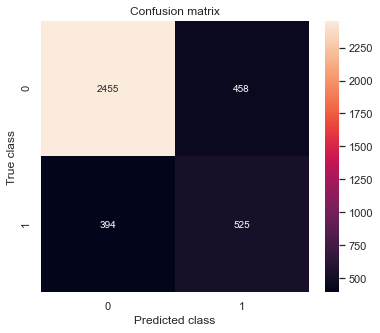

F1 score = 0.5520504731861199
              precision    recall  f1-score   support

         0.0       0.86      0.84      0.85      2913
         1.0       0.53      0.57      0.55       919

    accuracy                           0.78      3832
   macro avg       0.70      0.71      0.70      3832
weighted avg       0.78      0.78      0.78      3832



In [103]:
mostrar_resultados(y_test, y_pred)

# 5. Predicciones individuales

Vamos a comprobar el funcionamiento del proceso a la hora de predecir un único valor (es decir, una única línea del dataframe, lo que equivaldría a una respuesta individual de la futura encuesta):

In [104]:
# Probamos por ejemplo con la tercera observación del dataframe de test

x = X_test.iloc[2]
x = full_pipeline.transform(x)
y_pred = clf.predict(x)[0]
y = y_test.iloc[0]
print('Prediction: {}'.format(y_pred))
print('Ground truth: {}'.format(y))

Prediction: 1.0
Ground truth: 1.0
